In [1]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2


from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbStabilizerCode import FiveQbStabilizerCodeCircuit
from functions import *


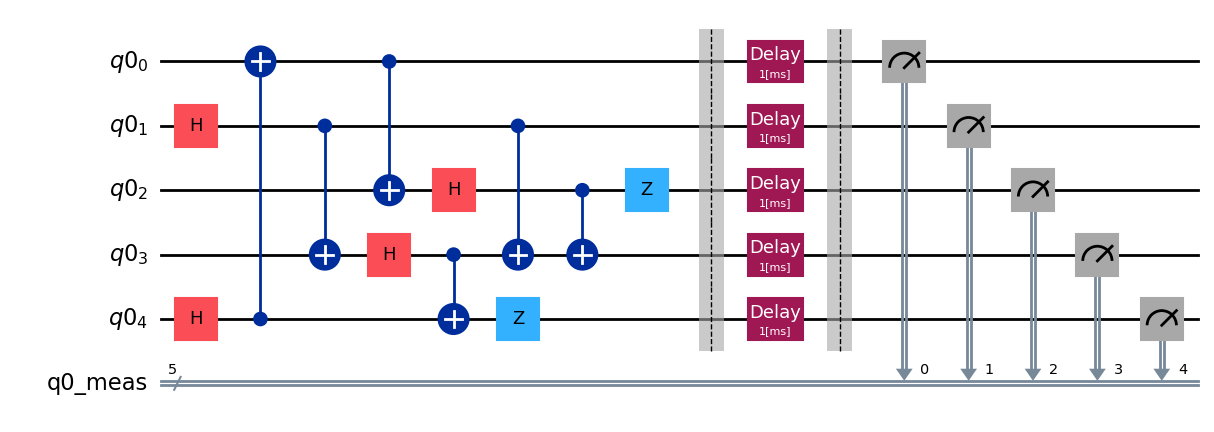

In [2]:


def load_circuit():
    qc = FiveQbStabilizerCodeCircuit(1)

    qc.encode(type='0')

    qc.delay(1, unit='ms')

    qc.measure_all()

    return qc

qc = load_circuit()
qc.draw('mpl')



In [4]:
# IonQ access
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [5]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

In [6]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
# print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')



Circuit Depth: 9


In [9]:
circuits = [isa_circuit]

In [10]:
simulation_result = sampler_simulation(qc.physical_circuit, 3200)

for lq in qc.qubits:
    # state = lq.qb_measure
    state = lq.qb_measures
    # state = lq.all_measures
    print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")


  q0_meas: {'01010': 186, '10100': 188, '00101': 216, '11011': 215, '00000': 219, '01100': 175, '01001': 207, '10111': 201, '00011': 180, '11110': 203, '10001': 206, '11000': 214, '00110': 193, '10010': 202, '11101': 201, '01111': 194}


Run experiment

In [ ]:
shots = 3200
# job = backend.run(circuits, shots=shots)
# # job = simulator_backend.run(circuits, shots=shots) # simulador
# job_id = job.id()
# # pub_result = job.result()
# print(f"Job ID: {job_id}")


Job ID: 6597366d-f61b-11ef-88c8-3800255d459d


In [ ]:
results = extract_results_json_IONQ('5qb_stabilizer_T1_delay1ms.json', type='percentage', reverse_order=True)[0]
print(results)

{'00000': 7.598499061913697, '00001': 0.594121325828643, '00010': 0.18761726078799248, '00011': 4.90931832395247, '00100': 0.37523452157598497, '00101': 5.222013758599124, '00110': 7.223264540337711, '00111': 0.8442776735459663, '01000': 0.40650406504065045, '01001': 7.16072545340838, '01010': 3.877423389618512, '01011': 0.5315822388993121, '01100': 4.50281425891182, '01101': 0.31269543464665417, '01110': 0.12507817385866166, '01111': 6.2539086929330825, '10000': 0.4377736085053158, '10001': 7.16072545340838, '10010': 4.940587867417136, '10011': 0.31269543464665417, '10100': 5.253283302063791, '10101': 0.2501563477173233, '10110': 0.28142589118198874, '10111': 7.2858036272670414, '11000': 6.629143214509068, '11001': 0.31269543464665417, '11010': 0.2188868042526579, '11011': 4.784240150093809, '11100': 0.5003126954346466, '11101': 3.7836147592245157, '11110': 7.098186366479049, '11111': 0.6253908692933083}


In [35]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]

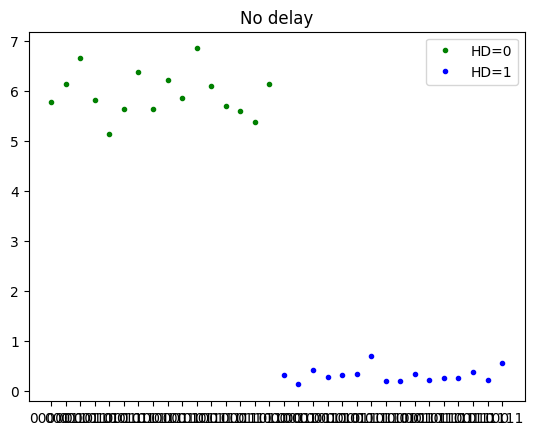

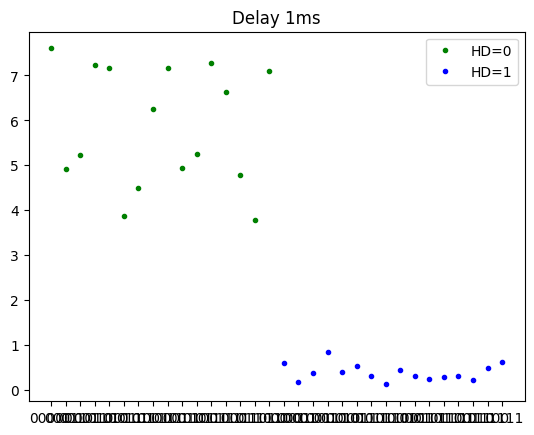

In [45]:
results_no_delay = extract_results_json_IONQ('5qb_stabilizer_T1_all_meas.json', type='percentage', reverse_order=True)[0]
plot_results_hamming_distance(results_no_delay, 5, valid_states, title='No delay')
plot_results_hamming_distance(results, 5, valid_states, title='Delay 1ms')

In [50]:
print(np.mean([
    value for key, value in results_no_delay.items() if key in valid_states
]))
print(np.mean([
    value for key, value in results_no_delay.items() if key not in valid_states
]))
print('snr:', np.mean([
    value for key, value in results_no_delay.items() if key in valid_states
])/np.mean([
    value for key, value in results_no_delay.items() if key not in valid_states
])
)

5.933494842138168
0.3165051578618318
snr: 18.74691358024691


In [51]:
print(np.mean([
    value for key, value in results.items() if key in valid_states
]))
print(np.mean([
    value for key, value in results.items() if key not in valid_states
]))
print('snr:', np.mean([
    value for key, value in results.items() if key in valid_states
])/np.mean([
    value for key, value in results.items() if key not in valid_states
])
)

5.855222013758599
0.39477798624140087
snr: 14.831683168316832


TVD

In [54]:
tvd_no_delay = calculate_tvd(results_no_delay, generate_uniform_distribution(5, valid_states), percentage=True)
tvd = calculate_tvd(results, generate_uniform_distribution(5, valid_states), percentage=True)

print("Total Variation Distance")
print(f"no delay:\t{round(tvd_no_delay*100,2)}%")
print(f"delay 1ms:\t{round(tvd*100,2)}%")

Total Variation Distance
no delay:	6.2%
delay 1ms:	12.73%
